# MarchMadness Twitter Analysis 

### Group C MBD Oct '21

<img width="600" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/en/thumb/2/28/March_Madness_logo.svg/800px-March_Madness_logo.svg.png" />
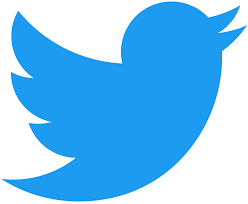

# Table of Content
* [1. Spark Setup](#1) 
  * [1.1 Search for Spark Installation](#1.1)
  * [1.2 Create Spark Session](#1.2)
  * [1.3 Read data as dataframe](#1.3)
* [2. Analysis I: Graph analytics](#2) 
  * [2.1 Extract hashtags from tweets](#2.1)
  * [2.2 Generate hashtag pairs](#2.2)
  * [2.3 Vertices, Edges, and Graphframe](#2.3)
  * [2.4 Analytical questions](#2.4)
  * [2.4 Visualizing the graph](#2.5)
* [3. Analysis II: Emoji EDA 🏀](#3)
* [4. Analysis III: Sentiment Analysis with SparkML😊😠](#4)
  * [4.1 Import the pre-annotated Twitter data from sentiment140](#4.1)
  * [4.2 Prepare for the model: Train test split, vectorizing the data](#4.2)
  * [4.3 Creating a classification model using Random Forest](#4.3)
  * [4.4 Apply the model to March Madness Tweets](#4.4)
  * [4.5 Serving with MariaDB](#4.5)
* [5. Analysis IV: Bot Detection with Spark ML 🤖](#5)
  * [5.1 Import the pre-annotated data set of Twitter bot from Indiana University](#5.1)
  * [5.2 Data pre-processing](#5.2)
  * [5.3 Modelling: classifying bots using random forest](#5.3)
  * [5.4 Grid Search to tune the hyperparamters](#5.4)
  * [5.5 Model Evaluation using Accuracy](#5.5)
  * [5.6 Apply the model to our Twitter user data](#5.6)
  * [5.7 Serving with MariaDB](#5.7)
* [6. Analysis V: Influencer Analysis](#6)
  * [6.1 Define Influencer Metrics](#6.1)
  * [6.2 Creating a user information dataframe](#6.2)
  * [6.3 Top users by Reach Score](#6.3)
  * [6.4 Top non-verified users](#6.4)
  * [6.5 Most influential team accounts](#6.5)

<a id='1'></a>

# 1. Spark Setup

<a id='1.1'></a>
### 1.1 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 40)
pd.set_option('display.max_columns', None)

<a id='1.2'></a>
### 1.2 Create Spark Session

By setting this environment variable we can include extra libraries in our Spark cluster.<br/>
We'll take advantage of this step to include that <b>Spark package to connecto to Kafka</b>.

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.3" --jars "/usr/share/java/mariadb-java-client.jar,/opt/hive3/lib/hive-hcatalog-core-3.1.2.jar" pyspark-shell'

In [4]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" --jars "/usr/share/java/mariadb-java-client.jar,/opt/hive3/lib/hive-hcatalog-core-3.1.2.jar" pyspark-shell'


In [5]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("March Madness")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .enableHiveSupport()
    .getOrCreate())

Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-411ae818-0e75-4155-985a-3ff833d062e2;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 291ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	------------------------------------------------------------

<a id='1.3'></a>
### 1.3 Read data as dataframe

In [6]:
tweets = spark.read.json("./home/osbdet/notebooks/data/marchmadness/2022/03/*")

In [82]:
# Let's see how many tweets and columns we have
print((tweets.count(), len(tweets.columns)))

(216673, 37)


In [83]:
tweets.limit(2).toPandas()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Fri Mar 11 23:05:13 +0000 2022,None,"([], [(None, None, pic.twitter.com/xbiAJwnK9T, https://twitter.com/boujeebasics_co/status/1502420292785750021/photo/...","([(None, None, pic.twitter.com/xbiAJwnK9T, https://twitter.com/boujeebasics_co/status/1502420292785750021/photo/1, 1...",None,0,False,low,None,1502420407575478273,1502420407575478273,None,NaN,None,NaN,None,True,en,None,False,0,"(None, None, Fri Mar 11 18:36:22 +0000 2022, [0, 140], ([Row(indices=[55, 68], text='MarchMadness')], None, [], [Row...",1502352750830514179,1502352750830514179,"(twitter.com/alexisfromvega…, https://twitter.com/alexisfromvegas/status/1502352750830514179, https://t.co/94nUhBTYD1)",0,0,False,"(None, None, Fri Mar 11 23:04:46 +0000 2022, [0, 19], ([], [Row(additional_media_info=None, description=None, displa...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @boujeebasics_co: we also have black! https://t.co/xbiAJwnK9T,1647039913444,False,"(False, Wed Jul 08 02:49:45 +0000 2009, False, False, vegas born and raised l former college 🎾 player l social, publ...",None
1,None,None,Sat Mar 12 20:03:17 +0000 2022,None,"([], [(None, If You Say So Reaction GIF by Identity, pic.twitter.com/9BBXKhSGmN, https://twitter.com/RJ_Writes/statu...","([(None, If You Say So Reaction GIF by Identity, pic.twitter.com/9BBXKhSGmN, https://twitter.com/RJ_Writes/status/15...",None,0,False,low,None,1502737010406088714,1502737010406088714,None,NaN,None,NaN,None,True,en,None,False,0,"(None, None, Sat Mar 12 19:56:50 +0000 2022, [21, 140], ([Row(indices=[60, 64], text='LSU')], None, [], [Row(display...",1502735386958868481,1502735386958868481,"(twitter.com/rossdellenger/…, https://twitter.com/rossdellenger/status/1502735386958868481, https://t.co/mX4yhkcQdw)",0,0,False,"(None, None, Sat Mar 12 20:01:04 +0000 2022, [0, 37], ([], [Row(additional_media_info=None, description='If You Say ...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @RJ_Writes: Got mans texting about the violations https://t.co/9BBXKhSGmN,1647115397441,False,"(False, Fri Apr 24 00:50:34 +0000 2009, False, False, The Father of The Bud and The Father of @RapRankings. Creator ...",None


In [84]:
tweets.select("user").limit(2).printSchema()

root
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- favourites_count: long (nullable = true)
 |    |-- follow_request_sent: string (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- following: string (nullable = true)
 |    |-- friends_count: long (nullable = true)
 |    |-- geo_enabled: boolean (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- id_str: string (nullable = true)
 |    |-- is_translator: boolean (nullable = true)
 |    |-- lang: string (nullable = true)
 |    |-- listed_count: long (nullable = true)
 |    |-- location: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- notifications: string (nullable = true)
 |    |-- profile_background_color: str

<a id='2'></a>
# 2. Analysis I: Graph analytics

<a id='2.1'></a>
### 2.1 Extract hashtags from tweets

In [8]:
from pyspark.sql.functions import *

def elements_by_tweets(df, entity):
    return (tweets.where(size(f"entities.{entity}.text") > 1)
                 .select("id","text",col(f"entities.{entity}.text").alias("elements")))


In [9]:
hashtags_by_tweet = elements_by_tweets(tweets,'hashtags')
hashtags_by_tweet.limit(5).toPandas()   

,id,text,elements
0,1502715995160412166,RT @CA_BroBets: Here we go #Gambling...,"[GamblingTwitter, soccer, SelectionS..."
1,1502667130713432067,RT @CA_BroBets: Here we go #Gambling...,"[GamblingTwitter, soccer, SelectionS..."
2,1502105590293794821,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]"
3,1502105331996016654,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]"
4,1502104982866346007,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]"


In [10]:
@udf("array<string>")
def upper_case(a):
    if not a:
        return a    
    return list(map(lambda x: x.upper(), a))

In [11]:
hashtags_by_tweets_fixed = hashtags_by_tweet.withColumn("hashtags",array_sort(array_distinct(upper_case("elements"))))
hashtags_by_tweets_fixed.limit(5).toPandas()

,id,text,elements,hashtags
0,1502715995160412166,RT @CA_BroBets: Here we go #Gambling...,"[GamblingTwitter, soccer, SelectionS...","[GAMBLINGTWITTER, SELECTIONSUNDAY, S..."
1,1502667130713432067,RT @CA_BroBets: Here we go #Gambling...,"[GamblingTwitter, soccer, SelectionS...","[GAMBLINGTWITTER, SELECTIONSUNDAY, S..."
2,1502105590293794821,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]","[MARCH, MARCHMADNESS]"
3,1502105331996016654,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]","[MARCH, MARCHMADNESS]"
4,1502104982866346007,RT @SharpestSports: Make it 4 straig...,"[March, MarchMadness]","[MARCH, MARCHMADNESS]"


Let's create all possible elements permutations

<a id='2.2'></a>
### 2.2 Generate hashtag pairs

In [12]:
from itertools import permutations

@udf("array<array<string>>")
def combine(a):
    return list(permutations(a, 2))
# Using permutationsinstead of permutation because order matters 

In [13]:
hashtag_pair_by_tweet = hashtags_by_tweets_fixed.select("id",combine("hashtags").alias("permutations"))
hashtag_pair_by_tweet.limit(5).toPandas()

,id,permutations
0,1502715995160412166,"[[GAMBLINGTWITTER, SELECTIONSUNDAY],..."
1,1502667130713432067,"[[GAMBLINGTWITTER, SELECTIONSUNDAY],..."
2,1502105590293794821,"[[MARCH, MARCHMADNESS], [MARCHMADNES..."
3,1502105331996016654,"[[MARCH, MARCHMADNESS], [MARCHMADNES..."
4,1502104982866346007,"[[MARCH, MARCHMADNESS], [MARCHMADNES..."


In [14]:
hashtags = (hashtag_pair_by_tweet
                     .select(explode("permutations").alias("pair"))
                     .select(col("pair")[0].alias("hashtag1"),
                             col("pair")[1].alias("hashtag2")))
                                                       
hashtags.limit(5).toPandas()

,hashtag1,hashtag2
0,GAMBLINGTWITTER,SELECTIONSUNDAY
1,GAMBLINGTWITTER,SOCCER
2,GAMBLINGTWITTER,WIN
3,SELECTIONSUNDAY,GAMBLINGTWITTER
4,SELECTIONSUNDAY,SOCCER


<a id='2.3'></a>
### 2.3 Vertices, Edges, and Graphframe

In [15]:
h_vertices = (hashtags.select("hashtag1").union(hashtags.select("hashtag2"))
           .distinct()           
           .withColumnRenamed("hashtag1","id"))
        
h_edges = (hashtags
            .withColumnRenamed("hashtag1","src")
            .withColumnRenamed("hashtag2","dst")
            .groupBy("src","dst")
            .agg(
                count("*").alias("occurrences")
            ))


In [16]:
h_vertices.count()

5175

In [17]:
h_vertices.limit(5).toPandas()

,id
0,PAC12
1,GUNSUP
2,SECCHAMPIONS
3,BOYSBASKETBALL
4,RUNJUMPFLYTHROW


In [18]:
h_edges.count()

33422

In [19]:
h_edges.orderBy(desc("occurrences")).limit(5).toPandas()

,src,dst,occurrences
0,SELECTIONSUNDAY,MARCHMADNESS,16573
1,MARCHMADNESS,SELECTIONSUNDAY,16573
2,MARCHMADNESS,NCAATOURNAMENT,1160
3,NCAATOURNAMENT,MARCHMADNESS,1160
4,GOBLUE,FORCOMPETITORSONLY,879


We are going to model our graph in the following way:<br/>
**vertices** :hashtags <br/>
**edges** : hashtags pairs aggregation

In [20]:
from graphframes import GraphFrame

In [21]:
hashtag_graph = GraphFrame(h_vertices, h_edges)
hashtag_graph.cache()

GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])

<a id='2.4'></a>
### 2.4 Analytical questions

#### which are the top 10 most common hashtags pairs?

In [22]:
hashtag_graph.edges.orderBy(desc("occurrences")).limit(10).toPandas()

,src,dst,occurrences
0,MARCHMADNESS,SELECTIONSUNDAY,16573
1,SELECTIONSUNDAY,MARCHMADNESS,16573
2,NCAATOURNAMENT,MARCHMADNESS,1160
3,MARCHMADNESS,NCAATOURNAMENT,1160
4,GOBLUE,FORCOMPETITORSONLY,879
5,FORCOMPETITORSONLY,GOBLUE,879
6,NCAATOURNAMENT,SELECTIONSUNDAY,825
7,SELECTIONSUNDAY,NCAATOURNAMENT,825
8,WAREAGLE,MARCHMADNESS,732
9,MARCHMADNESS,WAREAGLE,732


#### how many communities/clusters there are?

In [27]:
pd.set_option('display.max_colwidth', 120)

In [153]:
(hashtag_graph.stronglyConnectedComponents(maxIter=10)
     .sort("component")
     .groupby("component")
     .agg(collect_list("id").alias("TwitterHashtags"))).toPandas()

,component,TwitterHashtags
0,0,"[UTES, BBQ, BANNERNUMBER6, TERPS, TWITTERMADNESS, 8CLAP, WEGOINSANE, HAWAIISB, UCLAMBB, NJCAA, EBOOK, TNWS, CATAMOUN..."
1,12,"[LT, 3G]"
2,8589934602,"[FAKEACTOR, DAFLOP, THEFLOP]"
3,8589934604,"[REDBIRDBSSKETBALL, GOBIRDS]"
4,8589934605,"[GOBUFFS, ELEVATEYOURGAME]"
...,...,...
256,1374389534751,"[TOTALWAR, THESIMS]"
257,1374389534752,"[DESNEWS, UTAH]"
258,1425929142291,"[SONICTHEHEDGEHOG, HARRYPOTTER]"
259,1434519076873,"[DIRECTV, MYTHTV]"


In [166]:
!pwd


/home/osbdet/notebooks


In [169]:
!mkdir <pwd_output>/checkpoints


/bin/bash: pwd_output: No such file or directory


In [170]:
spark.sparkContext.setCheckpointDir('<pwd_output>/checkpoints')


In [172]:
(hashtag_graph.connectedComponents()
     .sort("component")
     .groupby("component")
     .agg(collect_list("id").alias("MMHashtags"))).toPandas()

,component,MMHashtags
0,0,"[PAC12, GUNSUP, SECCHAMPIONS, BOYSBASKETBALL, RUNJUMPFLYTHROW, UAB, MARRIOTTBONVOY, GOWLU, PRINCETON, MUNSONS, GESTA..."
1,12,"[LT, 3G]"
2,8589934602,"[FAKEACTOR, THEFLOP, DAFLOP]"
3,8589934604,"[GOBIRDS, REDBIRDBSSKETBALL]"
4,8589934605,"[GOBUFFS, ELEVATEYOURGAME]"
...,...,...
256,1374389534751,"[TOTALWAR, THESIMS]"
257,1374389534752,"[UTAH, DESNEWS]"
258,1425929142291,"[SONICTHEHEDGEHOG, HARRYPOTTER]"
259,1434519076873,"[DIRECTV, MYTHTV]"


#### which are the most relevant hashtags?
We are going to apply the Page Ranks algorithm

In [31]:
hashtag_rank = hashtag_graph.pageRank(resetProbability=0.15, maxIter=10)

In [32]:
hashtag_rank.vertices.orderBy(desc("pagerank")).limit(5).toPandas()

,id,pagerank
0,MARCHMADNESS,384.615978
1,NCAA,107.634358
2,SELECTIONSUNDAY,69.533240
3,COLLEGEBASKETBALL,48.919332
4,BASKETBALL,29.561056


Limiting to the top 100 vertices, otherwise, the knowledge graph will blow up with too many hashtags. Then we limit the edges as well.

In [129]:
vertices_limit = hashtag_rank.vertices.orderBy(desc("pagerank")).limit(100)
vertices_list = vertices_limit.toPandas()['id'].tolist()

In [133]:
edges_limit = hashtag_rank.edges.where(
    (hashtag_rank.edges.src.isin(vertices_list)) &  (hashtag_rank.edges.dst.isin(vertices_list)))

In [35]:
max_value = hashtag_rank.vertices.agg({"pagerank": "max"}).collect()[0][0]
max_value

384.61597766365344

In [33]:
hashtag_rank.edges.orderBy(desc("weight")).limit(5).toPandas()

,src,dst,occurrences,weight
0,NCAAQUARTERFINALS,GOMULES,2,1.0
1,YALEBULLDGODS,YALE,1,1.0
2,STIRFRIDAY,MARCHMADNESS,1,1.0
3,TRUTV,MARCHMADNESS,2,1.0
4,HOKIE,MARCHMADNESS,1,1.0


#### Visualize the results
Let's visualize the results.<br/>
I'm going to use **ipycytoscape** library 
https://js.cytoscape.org/
```sh
pip3 install ipycytoscape
jupyter nbextension enable --py ipycytoscape
```
You need to restart your VM

<a id='2.5'></a>
### 2.5 Visualizing the graph

In [148]:
#Updated
import random

hashtags_json = {}

vs = []
for v in vertices_limit.collect():
    data = {}
    data['id']=v.id
    data['label']=v.id
    data['pagerank']=v.pagerank
    data['color']="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    data['height'] = str(((v.pagerank/max_value)**0.5)*150)+'px'
    data['width'] = str(((v.pagerank/max_value)**0.5)*150)+'px'
    element = {}
    element['data']=data
    vs.append(element)
hashtags_json['nodes'] = vs

es = []
for e in edges_limit.collect():
    data = {}
    data['source']=e.src
    data['target']=e.dst
    data['occurrences']=e.occurrences
    data['weight']=e.weight   
    element = {}
    element['data']=data
    es.append(element)
hashtags_json['edges'] = es

In [152]:
import ipycytoscape

cytoscapeobj = ipycytoscape.CytoscapeWidget()
#adds the data
cytoscapeobj.graph.add_graph_from_json(hashtags_json)
#styles the nodes and egdes
cytoscapeobj.set_style([
            {
                'selector': 'node',
                'css': {'label': 'data(label)', 'background-color':'data(color)', 'width': 'data(width)', 'height': 'data(height)'}
            },                        
         
            {
                'selector': 'edge',
                'css': {"curve-style":"haystack","haystack-radius":0,"width":1.5,"opacity":'data(weight)*1.2',"line-color":"#a8eae5"}}            
])

cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'label': 'dat…

<a id='3'></a>
# 3. Analysis II: Emoji EDA 🏀

Execute the following command in terminal: pip3 install emojis

In [39]:
from pyspark.sql.functions import udf

import emojis

@udf("array<string>")
def get_emojis_udf(s):
    set = emojis.get(s)
    return [*set, ]

tweets.select(explode(get_emojis_udf("text")).alias("emoji"))\
      .groupBy("emoji").agg(count("*").alias("total")).orderBy(desc("total")).limit(20)\
      .toPandas()

,emoji,total
0,🕺,10673
1,🏀,7602
2,🔥,3117
3,🏆,3051
4,🚨,2737
5,‼️,2143
6,👀,2020
7,🙌,1850
8,💪,1829
9,📍,1704


<a id='4'></a>
# 4. Analysis III: Sentiment Analysis with SparkML 😊 😠 

We used RandomForestClassifier for its high accuracy. 
We trained the model with a pre-labelled dataset from Sentiment140

Source: http://help.sentiment140.com/for-students

<a id='4.1'></a>
### 4.1 Import the pre-annotated Twitter data from sentiment140

In [40]:
data = spark.read.options(header='false', inferschema='true').csv("trainingdata_sentiment140.csv")

In [41]:
data = data.withColumnRenamed("_c5", "text")
pd.set_option('display.max_colwidth', 120)

In [42]:
data.limit(10).toPandas()

,_c0,_c1,_c2,_c3,_c4,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [43]:
from pyspark.sql.functions import col

data.groupBy("_c0") \
    .count() \
    .orderBy(col("count").desc()) \
    .distinct() \
    .toPandas()
# _c0 represents the sentiment classification in the pre-labelled data
# 4 represent positive and 0 represent negative emotions

,_c0,count
0,4,800000
1,0,800000


In [44]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: long (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- text: string (nullable = true)



<a id='4.2'></a>
### 4.2 Prepare for the model: Train test split, vectorizing the data

In [45]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 1120669


Test Dataset Count: 479331


Conducting some data cleaning on the tweets

In [46]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

In [47]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [49]:
## regular expression tokenizer
# _c5 is the text of the Tweet
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
#
## stop words
add_stopwords = ["http","https","amp","rt","t","c","the","@"]
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
#
## bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)
#
## convert string labels to indexes
label_stringIdx = StringIndexer(inputCol = "_c0", outputCol = "label")

<a id='4.3'></a>
### 4.3 Creating a classification model using random forest

In [50]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)

Build the pipeline

In [51]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx, rf])

Fit the model with the training data

In [52]:
pipelineFit = pipeline.fit(trainingData)

Predict using the test set

In [53]:
predictions = pipelineFit.transform(testData)

Prediction result on the annotated dataset. Note that prediction 0 is positive sentiment and prediction 1 is negative sentiment

In [54]:
predictions.select("text","_c0","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 30, truncate = 40)

+----------------------------------------+---+----------------------------------------+-----+----------+
|                                    text|_c0|                             probability|label|prediction|
+----------------------------------------+---+----------------------------------------+-----+----------+
|@MGiraudOfficial http://twitpic.com/7...|  4|[0.5774144440057394,0.42258555599426056]|  0.0|       0.0|
|Hello and welcome to my Newest of fri...|  4|[0.5761553457646927,0.42384465423530726]|  0.0|       0.0|
|@mileycyrus Hey Miley, love your song...|  4| [0.5755031723823247,0.4244968276176753]|  0.0|       0.0|
|@dirkmshaw Awesome! Make sure you say...|  4| [0.5740537235708383,0.4259462764291618]|  0.0|       0.0|
|@joelpiper put in a good word to Kase...|  4|[0.5702097410273855,0.42979025897261447]|  0.0|       0.0|
|Good morning #JobAngels A very happy ...|  4| [0.5699065291500193,0.4300934708499808]|  0.0|       0.0|
|Wow thanks for all the followfriday l...|  4|[0.568917

In [55]:
predictions.groupBy('prediction').count().toPandas()

,prediction,count
0,0.0,269727
1,1.0,209604


Evaluate the model using Accuracy

In [56]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
print("Accuracy: %g" % (evaluator.evaluate(predictions)))

Accuracy: 0.708911


<a id='4.4'></a>
### 4.4 Apply the model to March Madness Tweets to get sentiment score classification

Conducting a de-duplicate because there are many duplicated tweets in the dataset

In [57]:
unique_tweet = tweets.dropDuplicates(['text'])

In [58]:
mm_predictions = pipelineFit.transform(unique_tweet)
mm_predictions.limit(10).toPandas()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries,words,filtered,features,rawPrediction,probability,prediction
0,None,None,Sun Mar 13 07:16:17 +0000 2022,None,"([([104, 109], NCAA)], [(Row(description=None, embeddable=None, monetizable=False, title=None), None, pic.twitter.co...","([(Row(description=None, embeddable=None, monetizable=False, title=None), None, pic.twitter.com/1slmNbh5mc, https://...",None,0,False,low,None,1502906378700087297,1502906378700087297,SportsballBot,1.502906e+18,1502906159061254146,4.283909e+09,4283909061,False,en,None,False,0,None,NaN,None,None,0,0,False,None,"<a href=""http://www.github.com/magnusnissel"" rel=""nofollow"">mn_nba_bot</a>","""Bill Walton was in rare form tonight.""\n\nhttps://t.co/1slmNbh5mc\n\n[via r/collegebasketball Mar 13, 2015 #NCAA]",1647155777989,False,"(False, Thu Nov 26 09:37:07 +0000 2015, False, False, Automated tweets, for human stuff follow @mainceltics instead....",None,"[bill, walton, was, in, rare, form, tonight, https, t, co, 1slmnbh5mc, via, r, collegebasketball, mar, 13, 2015, ncaa]","[bill, walton, was, in, rare, form, tonight, co, 1slmnbh5mc, via, r, collegebasketball, mar, 13, 2015, ncaa]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.56288881990696, 49.437111180093034]","[0.5056288881990696, 0.49437111180093035]",0.0
1,None,None,Sun Mar 13 01:01:33 +0000 2022,"[0, 140]","([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1502812069921501186, [109, 132], http...",None,"([0, 255], ([Row(indices=[225, 238], text='GoldStandard'), Row(indices=[241, 255], text='playwithHEART')], [Row(addi...",0,False,low,None,1502812069921501186,1502812069921501186,None,NaN,None,NaN,None,False,en,None,False,0,None,NaN,None,None,0,0,False,None,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>","""I am eager and excited to build on the great tradition the women's basketball program has at Charlotte."" -… https:/...",1647133293024,True,"(False, Wed Sep 21 15:52:22 +0000 2011, False, False, The official twitter account of Charlotte 49ers Women's Basket...",None,"[i, am, eager, and, excited, to, build, on, the, great, tradition, the, women, s, basketball, program, has, at, char...","[i, am, eager, and, excited, to, build, on, great, tradition, women, s, basketball, program, has, at, charlotte, co,...","(1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[51.63502846202305, 48.36497153797694]","[0.5163502846202305, 0.4836497153797694]",0.0
2,None,None,Fri Mar 11 02:22:44 +0000 2022,None,"([], None, [], [(twitter.com/i/web/status/1…, https://twitter.com/i/web/status/1502107725630783491, [116, 139], http...",None,"([0, 154], ([], None, [], [Row(display_url='outkick.com/will-wade-comm…', expanded_url='https://www.outkick.com/will...",0,False,low,None,1502107725630783491,1502107725630783491,None,NaN,None,NaN,None,False,en,None,False,0,None,NaN,None,None,0,0,False,None,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>","""I certainly look forward to commenting when it's all over.""\n-LSU basketball coach Will Wade on NCAA investigation…...",1646965364259,True,"(False, Wed Jul 13 21:39:52 +0000 2011, False, False, Fearless sports & politics ft. @ClayTravis @OutKick360 @OutKic...",None,"[i, certainly, look, forward, to, commenting, when, it, s, all, over, lsu, basketball, coach, will, wade,

In [59]:
mm_predictions.select('id',"text", "probability","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 30, truncate = 40)

+-------------------+----------------------------------------+----------------------------------------+----------+
|                 id|                                    text|                             probability|prediction|
+-------------------+----------------------------------------+----------------------------------------+----------+
|1502391908374622217|RT @HamlynJoshua: Thanks for your har...|[0.5588397213969883,0.44116027860301166]|       0.0|
|1503099201554579458|Love it. Congrats @buckets_teo !  Way...| [0.5551686742020815,0.4448313257979185]|       0.0|
|1502275479671386117|@glbyt your name has awesome allitera...|[0.5536459788248426,0.44635402117515743]|       0.0|
|1502682424966361092|Congrats @coachmull2! Happy for you, ...|[0.5499124871884916,0.45008751281150844]|       0.0|
|1502714955816185860|RT @CoachWB33: Congrats @coachmull2! ...|[0.5499124871884916,0.45008751281150844]|       0.0|
|1503097317221613568|This is what love and family look lik...| [0.54887124592188

Prediction zero is positive sentiment and prediction one is negative sentiment

In [60]:
mm_predictions.groupBy('prediction').count().toPandas()

,prediction,count
0,0.0,83057
1,1.0,23741


In [123]:
# Select all tweets with negative emotions
pd.set_option('display.max_colwidth', 120)
cols = ['id','text','probability','prediction']
neg_tweets = mm_predictions.filter(mm_predictions.prediction == 1).select(*cols)
neg_tweets

DataFrame[id: bigint, text: string, probability: vector, prediction: double]

In [124]:
neg_tweets.select('id', 'text', 'prediction') \
    .orderBy('probability', ascending= False) \
    .limit(10).toPandas()

,id,text,prediction
0,1502759135716200461,I'd like this Tennessee team in the NCAA tournament a lot more if I didn't know who their head coach was.,1.0
1,1502166906760957964,"@VOlthoff Rough night?!?!?!? Vicki, that’s a nice ‘understatement’! And… I (we were) was in the damn front row!!!… ...",1.0
2,1502266731154259972,RT @ItsPooda: I went here during the wrong time,1.0
3,1502099913827663872,I went here during the wrong time,1.0
4,1502752152569073665,"I also just realized that I put the wrong link, here’s the correct one\n\nhttps://t.co/64qFp032JL",1.0
5,1502074071299010563,RT @BetandWinHere: Get my #MarchMadness package: https://t.co/xTk0P9Y85N\n\nand watch my YouTube for #ncaabpicks #fr...,1.0
6,1502293564134653952,Get my #MarchMadness package: https://t.co/YAPambZmD6\n\nand watch my YouTube for #ncaabpicks #freepicks https://t.c...,1.0
7,1502782251733598208,Met my monthly goal for March already 🥳 let’s get it ! #MarchMadness ✨,1.0
8,1503134397591085061,"""Did Young Sheldon get in? He's always my number 1 seed for comedy!"" \n#SelectionSunday #MarchMadness2022… https://...",1.0
9,1502079626675376144,RT @upset_picks: Get my #MarchMadness package: https://t.co/YAPamcgpF6\n\nand watch my YouTube for #ncaabpicks #free...,1.0


In [121]:
# Select all tweets with positive emotions
pd.set_option('display.max_colwidth', 120)
cols = ['id','text','probability','prediction']
pos_tweets = mm_predictions.filter(mm_predictions.prediction == 0).select(*cols)
pos_tweets

DataFrame[id: bigint, text: string, probability: vector, prediction: double]

In [125]:
pos_tweets.select('id', 'text', 'prediction') \
    .orderBy('probability', ascending= True) \
    .limit(10).toPandas()

,id,text,prediction
0,1503134699622998017,"5 for Iowa??? If you have a spot In NCAA tournament locked in, there’s no point in even playing in the conference to...",0.0
1,1503151703973150720,Looking at these teams you might say boring but college basketball fans see this and think upset city. Thrilled for…...,0.0
2,1502832031528587264,Spending my Saturday at the cigar lounge watching the games #NC #golf #MarchMadness https://t.co/xrK8JGsmbp,0.0
3,1503137516496506889,This dude is going to act like MSU didn't make about 4-5 tourneys that they shouldn't have made.,0.0
4,1502693974292770817,RT @UConnNetch: This is a very subtle way of saying we have one week to make navy throwbacks,0.0
5,1502741015475720202,@keepsit1000 This is the NCAA. They have consistently shown their inability to do the right thing. Some ADs and ins…...,0.0
6,1502743204654895109,We have recently announced our first annual “SDN Madness” contest! This contest is free to play and free to win! Fo…...,0.0
7,1502655288448589830,This is a very subtle way of saying we have one week to make navy throwbacks,0.0
8,1503160419329916928,@HooHooKathie Kathie this is the 10% rule. 10% of something is better than 100% of nothing. IU may have to start wi…...,0.0
9,1503167280229883912,"Your girls should’ve been higher, but congratulations @YolettMcCuin &amp; @OleMissWBB 🎉 #NoCeilings #MarchMadness ht...",0.0


<a id='4.5'></a>
### 4.5 Serving with MariaDB

In [64]:
url = "jdbc:mariadb://localhost:3306/marchmadness"
table = "neg_tweets"
mode = "append"
props = {"user": "osbdet",
             "password":"osbdet123$", 
             "driver":"org.mariadb.jdbc.Driver"}

(neg_tweets.select('id', 'text', 'prediction') 
        .write
        .jdbc(url,table,mode,props)
     )

In [65]:
url = "jdbc:mariadb://localhost:3306/marchmadness"
table = "pos_tweets"
mode = "append"
props = {"user": "osbdet",
             "password":"osbdet123$", 
             "driver":"org.mariadb.jdbc.Driver"}

(pos_tweets.select('id', 'text', 'prediction') 
        .write
        .jdbc(url,table,mode,props)
     )

Navigate to the terminal

<a id='5'></a>
# 5. Analysis IV: Bot Detection with Spark ML 🤖

<a id='5.1'></a>
### 5.1 Import the pre-annotated data set of Twitter bot from Indiana University
Source: https://botometer.osome.iu.edu/bot-repository/datasets.html

In [66]:
training_bots = spark.read.json("accounts.json")
training_bots_classification = spark.read.option("delimiter",r'\t').csv("classification_bot.tsv")

In [67]:
training_bots.limit(10).toPandas()

,created_at,user
0,Wed May 15 16:00:19 +0000 2019,"(False, Fri Feb 06 22:33:59 +0000 2015, True, False, , (([],), None), 2305, False, 218, False, 285, False, False, 30..."
1,Thu May 16 20:07:35 +0000 2019,"(False, Thu Jul 14 18:37:00 +0000 2016, True, False, ➡ here we promote all of the boys' music 🐼💖\n\n➡ DM me if you w..."
2,Fri May 17 17:22:28 +0000 2019,"(False, Sun Aug 27 13:43:12 +0000 2017, True, False, Sii il cambiamento, (([],), None), 6443, False, 287, False, 346..."
3,Mon Sep 24 13:01:10 +0000 2018,"(False, Sat Jan 17 11:03:24 +0000 2015, True, False, , (([],), None), 1202, False, 266, False, 354, False, False, 29..."
4,Wed May 15 16:41:07 +0000 2019,"(False, Sat Jan 28 20:12:33 +0000 2017, True, False, Se puoi sognarlo puoi farlo 💙, (([],), None), 2511, False, 286,..."
5,Wed May 15 18:54:02 +0000 2019,"(False, Tue Mar 06 15:08:18 +0000 2018, True, False, , (([],), None), 15244, False, 26, False, 48, False, True, 9710..."
6,Mon Jul 02 11:28:53 +0000 2018,"(False, Thu Jun 28 08:55:52 +0000 2018, True, False, , (([],), None), 52, False, 15, False, 24, False, False, 101225..."
7,Sat Jun 30 02:11:15 +0000 2018,"(False, Wed May 30 17:11:01 +0000 2018, True, False, , (([],), None), 37, False, 19, False, 52, False, False, 100187..."
8,Tue Apr 30 12:16:50 +0000 2019,"(False, Tue Aug 11 06:15:29 +0000 2015, True, False, Gruppo di pazzi amanti del Leone francese, (([],), ([Row(displa..."
9,Fri May 17 21:09:13 +0000 2019,"(False, Sun Jun 24 10:32:14 +0000 2012, False, False, Buonista UN CAZZOll, (([],), None), 46531, False, 286, False, ..."


Let's use information related to the user to make prediction

<a id='5.2'></a>
### 5.2 Data pre-processing

In [68]:
training_bots.select('user').printSchema()

root
 |-- user: struct (nullable = true)
 |    |-- contributors_enabled: boolean (nullable = true)
 |    |-- created_at: string (nullable = true)
 |    |-- default_profile: boolean (nullable = true)
 |    |-- default_profile_image: boolean (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- entities: struct (nullable = true)
 |    |    |-- description: struct (nullable = true)
 |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |    |    |-- url: string (nullable = true)
 |    |    |-- url: struct (nullable = true)
 |    |    |    |-- urls: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = 

In [69]:
bots_df = training_bots.select('user.id',
                     'user.contributors_enabled',
                     'user.default_profile',
                     'user.default_profile_image',
                     'user.favourites_count',
                     'user.followers_count',
                     'user.friends_count',
                     'user.listed_count',
                     'user.geo_enabled',
                     'user.statuses_count',
                     'user.is_translator',
                     'user.profile_background_tile',
                     'user.profile_use_background_image',
                     'user.protected',
                     'user.verified'
                    )

bots_df

DataFrame[id: bigint, contributors_enabled: boolean, default_profile: boolean, default_profile_image: boolean, favourites_count: bigint, followers_count: bigint, friends_count: bigint, listed_count: bigint, geo_enabled: boolean, statuses_count: bigint, is_translator: boolean, profile_background_tile: boolean, profile_use_background_image: boolean, protected: boolean, verified: boolean]

In [70]:
training_bots_classification = training_bots_classification.withColumnRenamed(
                                                    "_c0","id").withColumnRenamed("_c1","bot_target")
training_bots_classification

DataFrame[id: string, bot_target: string]

We can merge both the json tweet dataframe with the target dataframe to a unique one

In [71]:
from pyspark.sql.functions import col

bots_df_model = bots_df.alias('a').join(training_bots_classification.alias('b'),
                        col('b.id')==col('a.id')).select('a.*','b.bot_target')

bots_df_model.toPandas()

,id,contributors_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,listed_count,geo_enabled,statuses_count,is_translator,profile_background_tile,profile_use_background_image,protected,verified,bot_target
0,3022357312,False,True,False,2305,218,285,0,False,3477,False,False,True,False,False,bot
1,753659579582541824,False,True,False,7561,256,358,0,True,5614,False,False,True,False,False,bot
2,901802279623417856,False,True,False,6443,287,346,3,False,5545,False,False,True,False,False,human
3,2982392825,False,True,False,1202,266,354,0,False,6022,False,False,True,False,False,bot
4,825436422609969152,False,True,False,2511,286,564,0,False,3915,False,False,True,False,False,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2982573165,False,True,False,1002,152,46,0,True,2134,False,False,True,False,False,bot
689,825698658695905280,False,True,False,546,301,863,0,False,3938,False,False,True,False,False,bot
690,751371698327416832,False,True,False,6953,35,33,26,False,6858,False,False,True,False,False,bot
691,726755736236253184,False,True,False,13631,134,155,1,True,12439,False,False,True,False,False,human


In order to use the stringindexer later on in order to convert True / False into binary representation, the boolean columns are transformed into string first, using the following for loop

In [72]:
for j in bots_df_model.dtypes:
    if j[1] =='boolean':
        bots_df_model = bots_df_model.withColumn(j[0], bots_df_model[j[0]].cast('string'))

In [73]:
# Double check that the casting is successful
bots_df_model.dtypes

[('id', 'bigint'),
 ('contributors_enabled', 'string'),
 ('default_profile', 'string'),
 ('default_profile_image', 'string'),
 ('favourites_count', 'bigint'),
 ('followers_count', 'bigint'),
 ('friends_count', 'bigint'),
 ('listed_count', 'bigint'),
 ('geo_enabled', 'string'),
 ('statuses_count', 'bigint'),
 ('is_translator', 'string'),
 ('profile_background_tile', 'string'),
 ('profile_use_background_image', 'string'),
 ('protected', 'string'),
 ('verified', 'string'),
 ('bot_target', 'string')]

In [74]:
# Select the categorical features as a list. Note that their data type is string now
categorical_features = bots_df_model.select(
                    [i[0] for i in bots_df_model.dtypes if 'str' in i[1]]).toPandas().columns
categorical_features = list(categorical_features)
categorical_features

['contributors_enabled',
 'default_profile',
 'default_profile_image',
 'geo_enabled',
 'is_translator',
 'profile_background_tile',
 'profile_use_background_image',
 'protected',
 'verified',
 'bot_target']

In [75]:
# Converting the categorical (True/False) into binary using StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(
                                                            bots_df_model) for column in categorical_features]

index_pipeline = Pipeline(stages=indexers)
bots_df_model = index_pipeline.fit(bots_df_model).transform(bots_df_model)

bots_df_model.toPandas()

# Now for each categorical variable, we have the index version (binary) on this df

,id,contributors_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,listed_count,geo_enabled,statuses_count,is_translator,profile_background_tile,profile_use_background_image,protected,verified,bot_target,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index,bot_target_index
0,3022357312,false,true,false,2305,218,285,0,false,3477,false,false,true,false,false,bot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,753659579582541824,false,true,false,7561,256,358,0,true,5614,false,false,true,false,false,bot,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,901802279623417856,false,true,false,6443,287,346,3,false,5545,false,false,true,false,false,human,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2982392825,false,true,false,1202,266,354,0,false,6022,false,false,true,false,false,bot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,825436422609969152,false,true,false,2511,286,564,0,false,3915,false,false,true,false,false,bot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2982573165,false,true,false,1002,152,46,0,true,2134,false,false,true,false,false,bot,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
689,825698658695905280,false,true,false,546,301,863,0,false,3938,false,false,true,false,false,bot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,751371698327416832,false,true,false,6953,35,33,26,false,6858,false,false,true,false,false,bot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,726755736236253184,false,true,false,13631,134,155,1,true,12439,false,false,true,false,false,human,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [76]:
# Drop the original categorical features represented in True / False
bots_df_model = bots_df_model.drop(*categorical_features)
bots_df_model.toPandas()

,id,favourites_count,followers_count,friends_count,listed_count,statuses_count,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index,bot_target_index
0,3022357312,2305,218,285,0,3477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,753659579582541824,7561,256,358,0,5614,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,901802279623417856,6443,287,346,3,5545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2982392825,1202,266,354,0,6022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,825436422609969152,2511,286,564,0,3915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2982573165,1002,152,46,0,2134,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
689,825698658695905280,546,301,863,0,3938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
690,751371698327416832,6953,35,33,26,6858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
691,726755736236253184,13631,134,155,1,12439,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [77]:
bots_df_model.groupBy('bot_target_index').count().toPandas()
# zero means bot
# the training dataset is very balanced

,bot_target_index,count
0,0.0,353
1,1.0,340


<a id='5.3'></a>
### 5.3 Modelling: classifying bots using random forest

The data processing is done. We can start assembling the model and train it

In [78]:
X = bots_df_model.drop(*['id','bot_target_index']).columns
y = 'bot_target_index'

In [79]:
from pyspark.ml.feature import VectorAssembler

# Assemble all the features into vector
assembler = VectorAssembler(inputCols=X, outputCol="feature_vector")
bots_df_model = assembler.transform(bots_df_model)

Train test split so that we can validate the model accuracy later

In [80]:
(trainingBotData, testBotData) = bots_df_model.randomSplit([0.8, 0.2], seed = 42)
print("Training Dataset Count: " + str(trainingBotData.count()))
print("Test Dataset Count: " + str(testBotData.count()))

Training Dataset Count: 583
Test Dataset Count: 110


In [81]:
trainingBotData.limit(3).toPandas()

# Scroll to the very right and notice that feature_vector is properly prepared

,id,favourites_count,followers_count,friends_count,listed_count,statuses_count,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index,bot_target_index,feature_vector
0,1123481,60807,2061,2831,81,63945,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"(60807.0, 2061.0, 2831.0, 81.0, 63945.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,3500831,3860,1912,1583,125,195705,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,"(3860.0, 1912.0, 1583.0, 125.0, 195705.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
2,14906561,73053,17419,11121,3291,907461,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(73053.0, 17419.0, 11121.0, 3291.0, 907461.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


<a id='5.4'></a>
### 5.4 Grid Search to tune the hyperparamters

In [82]:
rf = RandomForestClassifier(labelCol=y, featuresCol='feature_vector',numTrees=100, seed=42)

In [83]:
model = rf.fit(trainingBotData)

Run grid search to find the best number of trees

In [84]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [85]:
rf = RandomForestClassifier(labelCol = 'bot_target_index', featuresCol = 'feature_vector', numTrees=10, seed=42)
#pipeline = Pipeline(stages = rf)
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [80, 100, 120, 150, 180]).build()

crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(labelCol='bot_target_index'),
                          numFolds = 5) 

cvModel = crossval.fit(trainingBotData)

In [86]:
bestModel = cvModel.bestModel
bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_f628ca46a653, numTrees=150, numClasses=2, numFeatures=14

<a id='5.5'></a>
### 5.5 Model Evaluation using Accuracy

In [87]:
prediction_gs = cvModel.transform(testBotData)

In [88]:
evaluator_gs = MulticlassClassificationEvaluator(labelCol='bot_target_index', predictionCol='prediction')
accuracy_gs = evaluator_gs.evaluate(prediction_gs)
print("Accuracy = %s" % (accuracy_gs))

Accuracy = 0.7167085341842623


Taking a look at the prediction

In [89]:
prediction_gs.limit(3).toPandas()
# The last column 'prediction' is the model prediction, column 'bot_target_index' is the actual outcome
# 0 represents bot, 1 represents not a bot

,id,favourites_count,followers_count,friends_count,listed_count,statuses_count,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index,bot_target_index,feature_vector,rawPrediction,probability,prediction
0,14871003,5789,2404,1321,168,10221,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"(5789.0, 2404.0, 1321.0, 168.0, 10221.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[32.34940675027044, 117.65059324972954]","[0.21566271166846965, 0.7843372883315304]",1.0
1,22009205,101971,2108,3613,72,161880,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(101971.0, 2108.0, 3613.0, 72.0, 161880.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[21.49342727620604, 128.50657272379388]","[0.14328951517470703, 0.856710484825293]",1.0
2,32604352,1,2085,112,1597,179287,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(1.0, 2085.0, 112.0, 1597.0, 179287.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","[33.928300208279445, 116.07169979172052]","[0.22618866805519636, 0.7738113319448036]",1.0


<a id='5.6'></a>
### 5.6 Apply the model to our Twitter user data

In [90]:
user_df = tweets.select('user.id',
                     'user.contributors_enabled',
                     'user.default_profile',
                     'user.default_profile_image',
                     'user.favourites_count',
                     'user.followers_count',
                     'user.friends_count',
                     'user.listed_count',
                     'user.geo_enabled',
                     'user.statuses_count',
                     'user.is_translator',
                     'user.profile_background_tile',
                     'user.profile_use_background_image',
                     'user.protected',
                     'user.verified'
                    )

user_df.toPandas()

,id,contributors_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,listed_count,geo_enabled,statuses_count,is_translator,profile_background_tile,profile_use_background_image,protected,verified
0,54774735,False,False,False,76538,9451,2851,92,True,106051,False,False,True,False,False
1,34790175,False,False,False,78167,1174,998,29,False,227993,False,False,False,False,False
2,124776289,False,False,False,14862,1493,1339,2,True,8610,False,True,True,False,False
3,1486920248360067076,False,True,False,80,10,43,0,False,163,False,False,True,False,False
4,637216245,False,False,False,261224,2495,2960,17,True,119911,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216668,855888334945742848,False,True,False,261,7,50,0,False,128,False,False,True,False,False
216669,1500772679049166849,False,True,False,1,21,368,0,False,120,False,False,True,False,False
216670,836527833132347392,False,True,False,367,22,0,0,False,6688,False,False,True,False,False
216671,1502843933965131776,False,True,False,1,0,75,0,False,1,False,False,True,False,False


In [91]:
user_df = user_df.dropDuplicates(['id'])
user_df.toPandas()

,id,contributors_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,listed_count,geo_enabled,statuses_count,is_translator,profile_background_tile,profile_use_background_image,protected,verified
0,16399887,False,False,False,57172,1126,4978,41,True,20385,False,False,True,False,False
1,1378548753783738370,False,True,False,6021,58,75,0,False,799,False,False,True,False,False
2,812147087118725120,False,True,False,6270,237,498,5,True,2176,False,False,True,False,False
3,188366817,False,False,False,36478,1926,1250,60,True,26565,False,True,True,False,False
4,1471976667518283781,False,True,False,412,10,24,0,False,201,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113006,192948358,False,False,False,3325,72,274,0,False,6178,False,False,True,False,False
113007,793245493,False,False,False,281,36,208,2,False,1058,False,False,True,False,False
113008,796469589316145152,False,True,False,133156,208,703,1,True,2793,False,False,True,False,False
113009,1184276755064000513,False,True,False,28976,69,179,1,False,1138,False,False,True,False,False


Now we have a list of unique users

In [92]:
for j in user_df.dtypes:
    if j[1] =='boolean':
        user_df = user_df.withColumn(j[0], user_df[j[0]].cast('string'))

In [93]:
user_df.dtypes

[('id', 'bigint'),
 ('contributors_enabled', 'string'),
 ('default_profile', 'string'),
 ('default_profile_image', 'string'),
 ('favourites_count', 'bigint'),
 ('followers_count', 'bigint'),
 ('friends_count', 'bigint'),
 ('listed_count', 'bigint'),
 ('geo_enabled', 'string'),
 ('statuses_count', 'bigint'),
 ('is_translator', 'string'),
 ('profile_background_tile', 'string'),
 ('profile_use_background_image', 'string'),
 ('protected', 'string'),
 ('verified', 'string')]

In [94]:
# Select the categorical features as a list. Note that their data type is string now
user_cat_features = user_df.select(
                    [i[0] for i in user_df.dtypes if 'str' in i[1]]).toPandas().columns
user_cat_features = list(user_cat_features)
user_cat_features

['contributors_enabled',
 'default_profile',
 'default_profile_image',
 'geo_enabled',
 'is_translator',
 'profile_background_tile',
 'profile_use_background_image',
 'protected',
 'verified']

In [95]:
# Converting the categorical (True/False) into binary using StringIndexer

strindexers = [StringIndexer(inputCol = cols, outputCol = cols + "_index").fit(
                                                            user_df) for cols in user_cat_features]

index_pipeline = Pipeline(stages=strindexers)
user_df = index_pipeline.fit(user_df).transform(user_df)

user_df.toPandas()

# Now for each categorical variable, we have the index version (binary) on this df

,id,contributors_enabled,default_profile,default_profile_image,favourites_count,followers_count,friends_count,listed_count,geo_enabled,statuses_count,is_translator,profile_background_tile,profile_use_background_image,protected,verified,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index
0,16399887,false,false,false,57172,1126,4978,41,true,20385,false,false,true,false,false,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1378548753783738370,false,true,false,6021,58,75,0,false,799,false,false,true,false,false,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,812147087118725120,false,true,false,6270,237,498,5,true,2176,false,false,true,false,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,188366817,false,false,false,36478,1926,1250,60,true,26565,false,true,true,false,false,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1471976667518283781,false,true,false,412,10,24,0,false,201,false,false,true,false,false,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113006,192948358,false,false,false,3325,72,274,0,false,6178,false,false,true,false,false,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
113007,793245493,false,false,false,281,36,208,2,false,1058,false,false,true,false,false,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
113008,796469589316145152,false,true,false,133156,208,703,1,true,2793,false,false,true,false,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113009,1184276755064000513,false,true,false,28976,69,179,1,false,1138,false,false,true,false,false,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [96]:
user_df = user_df.drop(*user_cat_features)

In [97]:
X_user = user_df.drop('id').columns

In [98]:
from pyspark.ml.feature import VectorAssembler

# Assemble all the features into vector
assembler = VectorAssembler(inputCols=X_user, outputCol="feature_vector")
user_df = assembler.transform(user_df)

In [99]:
user_predictions = model.transform(user_df)

In [100]:
user_predictions.limit(3).toPandas()

,id,favourites_count,followers_count,friends_count,listed_count,statuses_count,contributors_enabled_index,default_profile_index,default_profile_image_index,geo_enabled_index,is_translator_index,profile_background_tile_index,profile_use_background_image_index,protected_index,verified_index,feature_vector,rawPrediction,probability,prediction
0,16399887,57172,1126,4978,41,20385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(57172.0, 1126.0, 4978.0, 41.0, 20385.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[14.891331619341424, 85.10866838065859]","[0.14891331619341422, 0.8510866838065857]",1.0
1,1378548753783738370,6021,58,75,0,799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"(6021.0, 58.0, 75.0, 0.0, 799.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[44.835171838020464, 55.164828161979536]","[0.44835171838020466, 0.5516482816197954]",1.0
2,812147087118725120,6270,237,498,5,2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(6270.0, 237.0, 498.0, 5.0, 2176.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","[52.07171749465635, 47.92828250534366]","[0.5207171749465634, 0.4792828250534366]",0.0


In [101]:
user_predictions.groupBy('prediction').count().toPandas()
# As a reminder, 0 is bot; 1 is person's account

,prediction,count
0,0.0,35894
1,1.0,77117


<a id='5.7'></a>
### 5.7 Serving with MariaDB

In [102]:
user_predictions

account_cols = ['id','prediction']
real_accounts = user_predictions.filter(user_predictions.prediction == 1).select(*account_cols)
bot_accounts = user_predictions.filter(user_predictions.prediction == 0).select(*account_cols)

In [103]:
url = "jdbc:mariadb://localhost:3306/marchmadness"
table = "real_accounts"
mode = "append"
props = {"user": "osbdet",
             "password":"osbdet123$", 
             "driver":"org.mariadb.jdbc.Driver"}

(real_accounts.select('id','prediction') 
        .write
        .jdbc(url,table,mode,props)
     )

In [104]:
url = "jdbc:mariadb://localhost:3306/marchmadness"
table = "bot_accounts"
mode = "append"
props = {"user": "osbdet",
             "password":"osbdet123$", 
             "driver":"org.mariadb.jdbc.Driver"}

(bot_accounts.select('id','prediction') 
        .write
        .jdbc(url,table,mode,props)
     )

<a id='6'></a>
# 6. Analysis V: Influencer Analysis

<a id='6.1'></a>
### 6.1 Define Influencer Metrics
Find out which accounts/people are tweeting the most about MarchMadness

1. Create metric to calculate Reach:
$$Reach Score = #Followers - #Following$$

$$Likes per follower = Total #Likes / #Followers$$

2. Find Verified Influencers

3. Find Non-verified Influencers

4. Find NCAA Teams

5. Identify number of hashtags used from selection

In [105]:
tweets.select('user.screen_name','user.verified', 'user.favourites_count').limit(10).show()

+---------------+--------+----------------+
|    screen_name|verified|favourites_count|
+---------------+--------+----------------+
|alexisfromvegas|   false|           76538|
|    Cam_Is_Like|   false|           78167|
|    karlgoodman|   false|           14862|
|   patterson_cl|   false|              80|
|        Bpquigs|   false|          261224|
|    BiffsSports|   false|            2717|
|   westcoasthky|   false|           16296|
|Jessie_Coffield|    true|           12654|
| TStellingwerff|   false|           16112|
|    barn_dancer|   false|           10382|
+---------------+--------+----------------+



In [106]:
tweets.where('user.verified=true').select(
    'user.screen_name', 'user.verified', 'user.followers_count','user.friends_count').limit(10).show()

+---------------+--------+---------------+-------------+
|    screen_name|verified|followers_count|friends_count|
+---------------+--------+---------------+-------------+
|Jessie_Coffield|    true|           4752|          509|
|      ktrain_11|    true|          12774|         7783|
|LongwoodLancers|    true|           7062|          915|
|     StavaonSTL|    true|           2016|         2731|
|   KrisKetzKMBC|    true|          30494|        16823|
| CurtWilkerson_|    true|           6883|         1793|
|       YogiRoth|    true|          26836|         1607|
|  ColeHunter520|    true|           4537|          610|
|     TXSOTigers|    true|          28506|          175|
|     SportsGrid|    true|          27831|         1449|
+---------------+--------+---------------+-------------+



<a id='6.1'></a>
### 6.2 Creating a df with user information

In [7]:
# Create seperate DataFrame for Users 
# Using: Name, verified, avg. number of Likes and Retweets, Followers and Following

users_df = (tweets
      .select('user.screen_name','user.verified','user.followers_count','user.friends_count',
              'user.favourites_count', 'entities', 'user.profile_image_url_https')
      .groupBy('screen_name','verified','followers_count','friends_count', 'profile_image_url_https')
      .agg({'favourites_count':'avg', 'entities':'count'}))

In [8]:
users_df.where('verified=true').orderBy('count(entities)').limit(5).show()

+-------------+--------+---------------+-------------+-----------------------+---------------+---------------------+
|  screen_name|verified|followers_count|friends_count|profile_image_url_https|count(entities)|avg(favourites_count)|
+-------------+--------+---------------+-------------+-----------------------+---------------+---------------------+
|   mullyhaugh|    true|          33833|         1695|   https://pbs.twimg...|              1|                529.0|
|CWilliamson44|    true|          10988|         3713|   https://pbs.twimg...|              1|             229525.0|
|  TomFornelli|    true|          78279|          574|   https://pbs.twimg...|              1|               4179.0|
|     abc4utah|    true|          70608|         4119|   https://pbs.twimg...|              1|               1593.0|
|         wibw|    true|          41467|          468|   https://pbs.twimg...|              1|                698.0|
+-------------+--------+---------------+-------------+----------

In [9]:
users_df = users_df.withColumn('Reach_score', users_df.followers_count - users_df.friends_count)
users_df = users_df.withColumn('likes_per_follow', users_df['avg(favourites_count)'] / users_df.followers_count)
users_df.limit(5).toPandas()

,screen_name,verified,followers_count,friends_count,profile_image_url_https,count(entities),avg(favourites_count),Reach_score,likes_per_follow
0,tiff_henry16,False,1578,628,https://pbs.twimg.com/profile_images...,1,10070.000000,950,6.381496
1,JaaZerW,False,855,971,https://pbs.twimg.com/profile_images...,1,77659.000000,-116,90.829240
2,JoggersAndSatay,False,2213,381,https://pbs.twimg.com/profile_images...,2,2781.000000,1832,1.256665
3,Jenford130,False,823,622,https://pbs.twimg.com/profile_images...,7,72695.285714,201,88.329630
4,_MatthewCletus,False,423,709,https://pbs.twimg.com/profile_images...,2,2496.000000,-286,5.900709


<a id='6.3'></a>
### 6.3 Top users by Reach Score

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number

In [111]:
top_users = users_df.orderBy(users_df.Reach_score.desc())\
.select('screen_name','Reach_score', 'profile_image_url_https')

w2 = Window.partitionBy("screen_name").orderBy(col("Reach_score"))

top_users = top_users.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row").orderBy(top_users.Reach_score.desc()).limit(10).toPandas()


In [112]:
top_users

,screen_name,Reach_score,profile_image_url_https
0,nytimes,52215515,https://pbs.twimg.com/profile_images/1098244578472280064/gjkVMelR_normal.png
1,SportsCenter,39738061,https://pbs.twimg.com/profile_images/1062155885911425024/EMf90GZI_normal.jpg
2,espn,39526933,https://pbs.twimg.com/profile_images/1170690523201527808/FriNRiir_normal.png
3,FoxNews,20893563,https://pbs.twimg.com/profile_images/1459143267673677853/xtIvtfZp_normal.jpg
4,washingtonpost,18935457,https://pbs.twimg.com/profile_images/1060271522319925257/fJKwJ0r2_normal.jpg
5,AP,15659661,https://pbs.twimg.com/profile_images/461964160838803457/8z9FImcv_normal.png
6,BleacherReport,11206268,https://pbs.twimg.com/profile_images/1266052551989919745/4D5slyzm_normal.jpg
7,AdamSchefter,9241041,https://pbs.twimg.com/profile_images/793924061843914752/ycm8ibEE_normal.jpg
8,NPR,8837140,https://pbs.twimg.com/profile_images/1419704144026296333/ms3D5ipo_normal.jpg
9,CBSNews,8523156,https://pbs.twimg.com/profile_images/1374394535883673604/4VIECtDH_normal.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  import sys


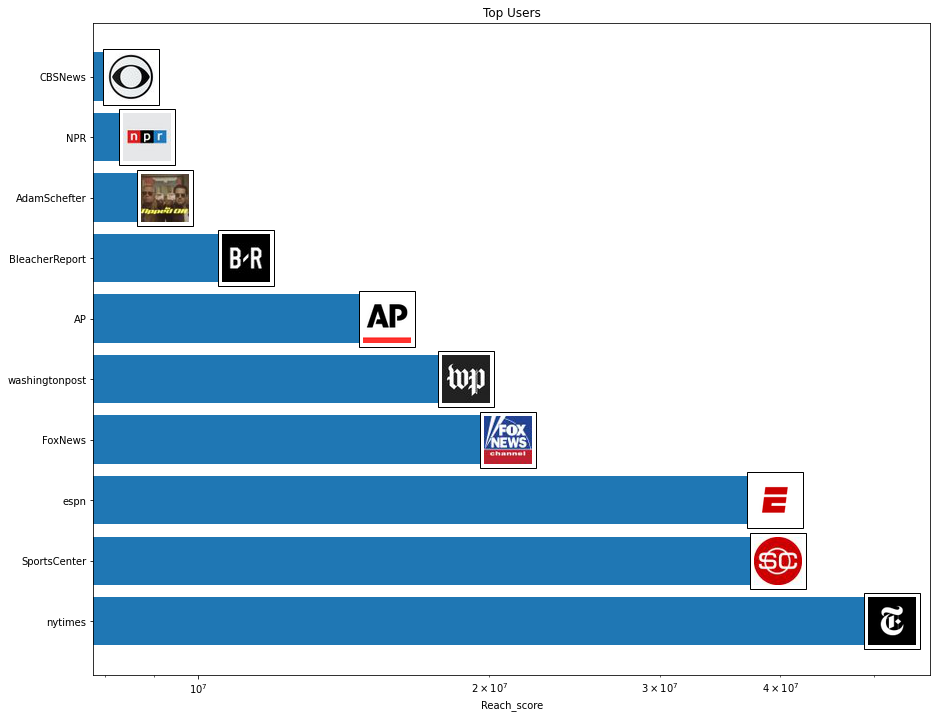

In [113]:
url = top_users['profile_image_url_https'].tolist()

user_list = top_users.screen_name.tolist()

images = []
for i in url:
    images.append(plt.imread(i, 'jpg'))
    
fig, ax = plt.subplots(figsize=(15, 12))

loc1 = 0

for image, score, j in zip(images, top_users['Reach_score'], range(len(top_users))):
    imagebox = OffsetImage(image, zoom=1)
        
    ab= AnnotationBbox(imagebox, (score, loc1))
        
    loc1 += 1
    ax.add_artist(ab)

plt.draw()
plt.barh(top_users['screen_name'], top_users['Reach_score'])
ax.set_xscale('log')
plt.savefig('add_picture_matplotlib_figure.png', bbox_inches='tight')
plt.title('Top Users')
plt.xlabel('Reach_score')
plt.show()

<a id='6.4'></a>
### 6.4 Top non-verified users

In [114]:
top_users_nv = users_df.where('verified=false').orderBy(users_df.Reach_score.desc())\
.select('screen_name','Reach_score', 'profile_image_url_https')

w2 = Window.partitionBy("screen_name").orderBy(col("Reach_score"))

top_users_nv = top_users_nv.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row").orderBy(top_users_nv.Reach_score.desc()).limit(10).toPandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  


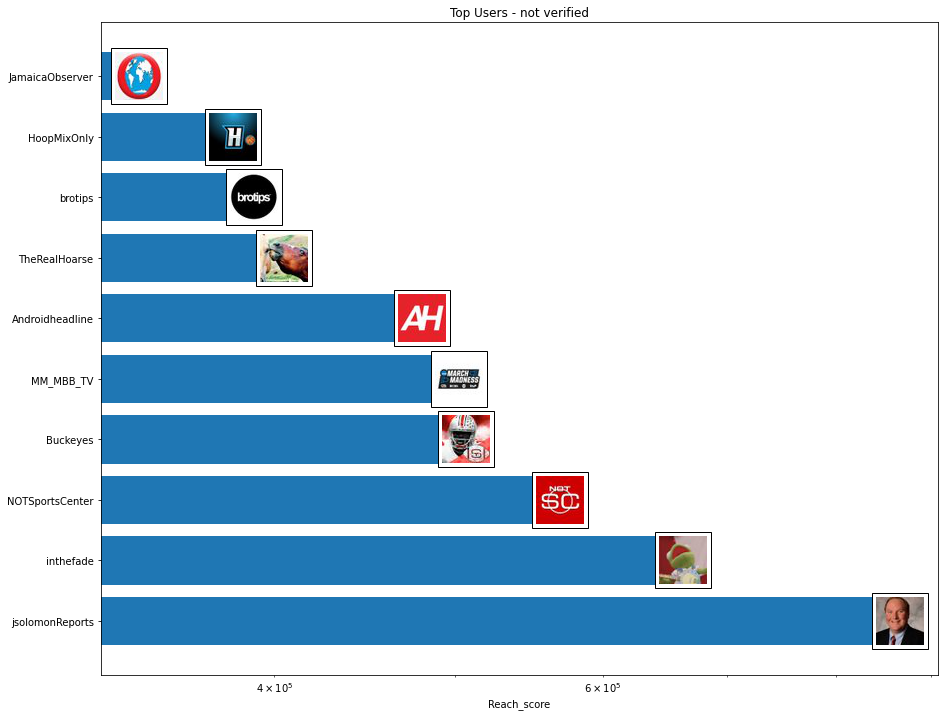

In [115]:
url = top_users_nv['profile_image_url_https'].tolist()

user_list = top_users_nv.screen_name.tolist()

images = []
for i in url:
    try:
        images.append(plt.imread(i, 'jpg'))
    except:
        images.append(plt.imread('https://media.istockphoto.com/photos/dotted-grid-paper-background-texture-seamless-repeat-pattern-picture-id1320330053?b=1&k=20&m=1320330053&s=170667a&w=0&h=XisfN35UnuxAVP_sjq3ujbFDyWPurSfSTYd-Ll09Ncc=', 'jpg'))

fig, ax = plt.subplots(figsize=(15, 12))

loc1 = 0

for image, score, j in zip(images, top_users_nv['Reach_score'], range(len(top_users_nv))):
    imagebox = OffsetImage(image, zoom=1)
        
    ab= AnnotationBbox(imagebox, (score, loc1))
        
    loc1 += 1
    ax.add_artist(ab)

plt.draw()
plt.barh(top_users_nv['screen_name'], top_users_nv['Reach_score'])
ax.set_xscale('log')
plt.savefig('add_picture_matplotlib_figure.png', bbox_inches='tight')
plt.title('Top Users - not verified')
plt.xlabel('Reach_score')
plt.show()

<a id='6.5'></a>
### 6.5 Most influential team accounts

In [48]:
teams_source = pd.read_csv('MBB Twitter Team Names @.csv', sep=";")
teams_source.head()

,Twitter_Team_Names,Twitter_handle,Unnamed: 2,URL
0,Gonzaga Basketball,ZagMBB,Verified,https://pbs.twimg.com/profile_images...
1,Duke Men’s Basketball,DukeMBB,Verified,https://pbs.twimg.com/profile_images...
2,Kansas Men’s Basketball,KUHoops,Verified,https://pbs.twimg.com/profile_images...
3,Arizona Basketball,ArizonaMBB,Verified,https://pbs.twimg.com/profile_images...
4,Ohio State Hoops,OhioStateHoops,Verified,https://pbs.twimg.com/profile_images...


In [13]:
teams_list = teams_source["Twitter_handle"].tolist()
print(teams_list)

['ZagMBB', 'DukeMBB', 'KUHoops', 'ArizonaMBB', 'OhioStateHoops', 'BadgerMBB', 'umichbball', 'RazorbackMBB', 'LSUBasketball', 'HokiesMBB', 'BaylorMBB', 'UConnMBB', 'BluejayMBB', 'MSU_Basketball', 'USC_Hoops', 'PCFriarsmbb', 'NDmbb', 'Vol_Hoops', 'AuburnMBB', 'Memphis_MBB', 'UNC_Basketball', 'MarquetteMBB', 'IlliniMBB', 'ZipsMBB', 'saintmaryshoops', 'WSU_MBB', 'wyo_mbb', 'IndianaMBB', 'NovaMBB', 'ColgateMBB', 'TexasTechMBB', 'RamblersMBB', 'KentuckyMBB', 'UAB_MBB', 'CycloneMBB', 'UCLAMBB', 'TCUBasketball', 'RacersHoops', 'RutgersMBB', 'UHCougarMBK', 'PeacocksMBB', 'BoilerBall', 'OregonMBB', 'Aztec_MBB', 'TexasMBB', 'TSUMensHoops', 'GoJacksMBB', 'DelawareMBB', 'LongwoodMBB', 'AlabamaMBB', 'IowaHoops']


In [14]:
teams_df = users_df.where(users_df.screen_name.isin(teams_list)).orderBy(users_df.Reach_score.desc())\
    .select('screen_name','Reach_score')
w2 = Window.partitionBy("screen_name").orderBy(col("Reach_score"))

top_teams = teams_df.withColumn("row",row_number().over(w2)) \
  .filter(col("row") == 1).drop("row").orderBy(teams_df.Reach_score.desc()).limit(10).toPandas()
top_teams

,screen_name,Reach_score
0,DukeMBB,2194734
1,IndianaMBB,1064513
2,KUHoops,917568
3,KentuckyMBB,818431
4,NDmbb,529113
5,MSU_Basketball,456668
6,umichbball,344868
7,BadgerMBB,310374
8,CycloneMBB,299278
9,ArizonaMBB,243214


In [39]:
teams_list2 = top_teams[:10]["screen_name"].tolist()
teams_list2

['DukeMBB',
 'IndianaMBB',
 'KUHoops',
 'KentuckyMBB',
 'NDmbb',
 'MSU_Basketball',
 'umichbball',
 'BadgerMBB',
 'CycloneMBB',
 'ArizonaMBB']

In [86]:
team_df1 = teams_source.where(teams_source.Twitter_handle.isin(teams_list2)).dropna()
team_df1.sort_values(by=['Twitter_handle'], ascending=True, inplace=True)
top_teams.sort_values(by=['screen_name'], ascending=True, inplace=True)
team_df1['Reach_score'] = top_teams['Reach_score'].values
team_df1.sort_values(by=['Reach_score'], ascending=False, inplace=True)
team_df1

,Twitter_Team_Names,Twitter_handle,Unnamed: 2,URL,Reach_score
1,Duke Men’s Basketball,DukeMBB,Verified,https://pbs.twimg.com/profile_images...,2194734
27,Indiana Basketball,IndianaMBB,Verified,https://pbs.twimg.com/profile_images...,1064513
2,Kansas Men’s Basketball,KUHoops,Verified,https://pbs.twimg.com/profile_images...,917568
32,Kentucky Men’s Basketball,KentuckyMBB,Verified,https://pbs.twimg.com/profile_images...,818431
16,Notre Dame Men's Basketball,NDmbb,Verified,https://pbs.twimg.com/profile_images...,529113
13,Michigan State Men's Basketball,MSU_Basketball,Verified,https://pbs.twimg.com/profile_images...,456668
6,Michigan Men's Basketball,umichbball,Verified,https://pbs.twimg.com/profile_images...,344868
5,Wisconsin Basketball,BadgerMBB,Verified,https://pbs.twimg.com/profile_images...,310374
34,Iowa State Men’s Basketball,CycloneMBB,Verified,https://pbs.twimg.com/profile_images...,299278
3,Arizona Basketball,ArizonaMBB,Verified,https://pbs.twimg.com/profile_images...,243214


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  import sys


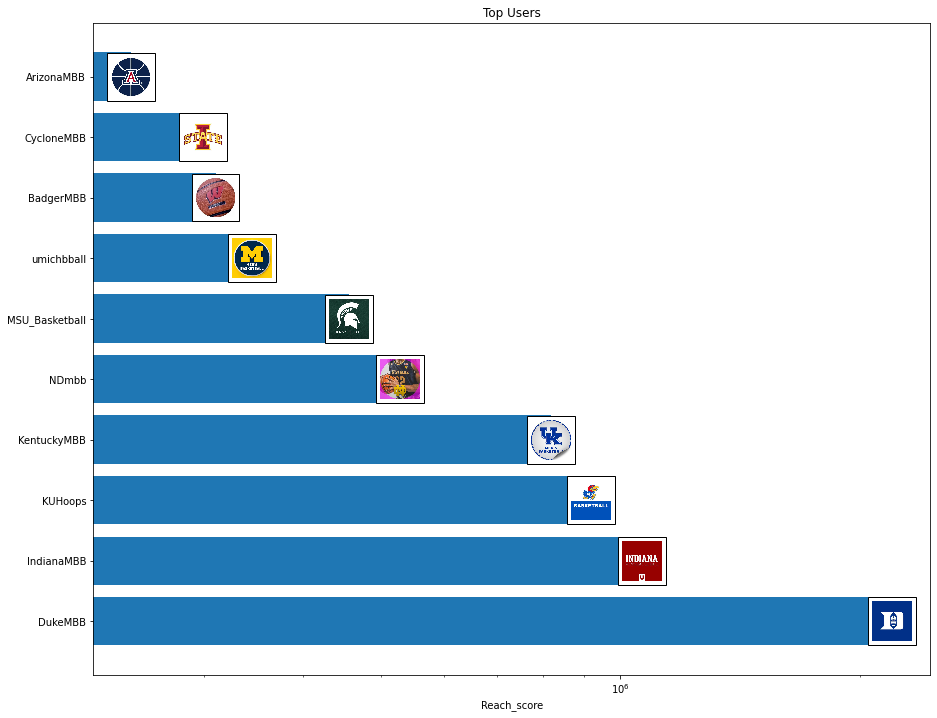

In [95]:
url = team_df1['URL'].tolist()

user_list = team_df1.Twitter_handle.tolist()

images = []
for i in url:
    images.append(plt.imread(i, 'jpg'))
    
fig, ax = plt.subplots(figsize=(15, 12))

loc1 = 0

for image, score, j in zip(images, team_df1['Reach_score'], range(len(team_df1))):
    imagebox = OffsetImage(image, zoom=0.1)
        
    ab= AnnotationBbox(imagebox, (score, loc1))
        
    loc1 += 1
    ax.add_artist(ab)

plt.draw()
plt.barh(team_df1['Twitter_handle'], team_df1['Reach_score'])
ax.set_xscale('log')
plt.savefig('add_picture_matplotlib_figure.png', bbox_inches='tight')
plt.title('Top Users')
plt.xlabel('Reach_score')
plt.show()

### Thank you for reading professor! We look forward to your feedback.
Group C